## Mesh Extraction from a fixed Signed Distance Field (SDF)

In this example, we demonstrate how to use FlexiCubes to extract a mesh from a fixed signed distance field (SDF) **without** optimization. Note that in this case, the extraction scheme used is the original Dual Marching Cubes [Nielson 2004] algorithm, with minor improvements in splitting. To begin with, we will establish two functions: one for calculating the SDF of a cube, and another for determining its analytic gradient. In your specific application, the SDF might be predicted by a network, with gradients computed through methods such as finite differences or autograd.

In [1]:
import torch
import kaolin as kal
from matplotlib import pyplot as plt

import render

In [2]:
def cube_sdf(x_nx3):
    sdf_values = 0.5 - torch.abs(x_nx3)
    sdf_values = torch.clamp(sdf_values, min=0.0)
    sdf_values = sdf_values[:, 0] * sdf_values[:, 1] * sdf_values[:, 2]
    sdf_values = -1.0 * sdf_values

    return sdf_values


def cube_sdf_gradient(x_nx3):
    gradients = []
    for i in range(x_nx3.shape[0]):
        x, y, z = x_nx3[i]
        grad_x, grad_y, grad_z = 0, 0, 0

        max_val = max(abs(x) - 0.5, abs(y) - 0.5, abs(z) - 0.5)

        if max_val == abs(x) - 0.5:
            grad_x = 1.0 if x > 0 else -1.0
        if max_val == abs(y) - 0.5:
            grad_y = 1.0 if y > 0 else -1.0
        if max_val == abs(z) - 0.5:
            grad_z = 1.0 if z > 0 else -1.0

        gradients.append(torch.tensor([grad_x, grad_y, grad_z]))

    return torch.stack(gradients).to(x_nx3.device)

Next, let's call upon FlexiCubes to extract the mesh from this SDF, both with and without providing the gradient information.

In [3]:
res = 5
device='cuda'
fc = kal.non_commercial.FlexiCubes(device)
voxelgrid_vertices, cube_idx = fc.construct_voxel_grid(res)
voxelgrid_vertices *= 1.1 # add small margin to boundary
scalar_field = cube_sdf(voxelgrid_vertices)

mesh_with_grad_v, mesh_with_grad_f, _ = fc(
    voxelgrid_vertices, scalar_field, cube_idx, res, grad_func=cube_sdf_gradient)

mesh_with_grad = kal.rep.SurfaceMesh(vertices=mesh_with_grad_v, faces=mesh_with_grad_f)
mesh_no_grad_v, mesh_no_grad_f, _ = fc(
    voxelgrid_vertices, scalar_field, cube_idx, res)

mesh_no_grad = kal.rep.SurfaceMesh(vertices=mesh_no_grad_v, faces=mesh_no_grad_f)

Now we visualize the two meshes. Without the gradient information (left), the extracted vertex locations are positioned at the centroids of the primal (Marching Cubes) mesh. Consequently, this method fails to reconstruct the sharp features present in the cube.

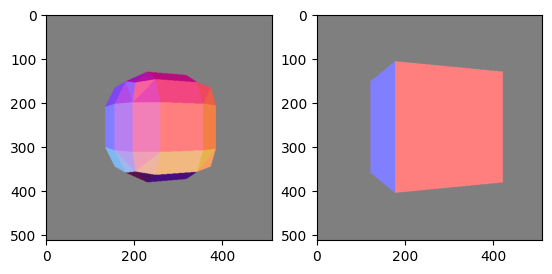

In [4]:
camera = render.get_rotate_camera(0, iter_res=[512, 512], device=device)
f, ax = plt.subplots(1, 2)
output = render.render_mesh(mesh_no_grad, camera, [512, 512], return_types=['normals'])
ax[0].imshow(((output['normals'][0] + 1) / 2.).cpu())
output = render.render_mesh(mesh_with_grad, camera, [512, 512], return_types=['normals'])
ax[1].imshow(((output['normals'][0] + 1) / 2.).cpu())
plt.show()

We can also visualize interactively with [kaolin's interactive visualizer](https://kaolin.readthedocs.io/en/latest/modules/kaolin.visualize.html), by moving around the camera and adjusting a wireframe to see the topology of the meshes.

In [5]:
render.SplitVisualizer(mesh_no_grad, mesh_with_grad, 512, 512).show(camera)

Output()